In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
import datetime as dt

In [2]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical
import keras 

In [3]:
import matplotlib as mpl
mpl.rc('font', size=15)

In [4]:
def add_date_data(DF):
    DF_dates=pd.DataFrame({'date':DF.date.unique(),'year':0,'year_week':0,
                          'month':0,'month_day':0,
                          'year_day':0,'weekday':0,
                          'week':0})

    for ind in DF_dates.index:
        date=DF_dates.date[ind]
        date_st=date.timetuple()
        DF_dates.loc[ind,'year']=date_st.tm_year
        DF_dates.loc[ind,'month']=date_st.tm_mon
        DF_dates.loc[ind,'month_day']=date_st.tm_mday
        DF_dates.loc[ind,'year_day']=date_st.tm_yday
        DF_dates.loc[ind,'weekday']=date_st.tm_wday
        DF_dates.loc[ind,'year_week']=date.isocalendar()[0]
        DF_dates.loc[ind,'week']=date.isocalendar()[1]
        
        
    DF=DF.merge(DF_dates, on='date')
    return DF

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([0, len(loss)+5, 0, 1.1*max(max(loss),max(val_loss))])
    plt.legend(fontsize=10)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# Import Data.
## Energy Generated

In [5]:
Energy=pd.read_csv('../../Data/subsystem_all_dams/Energy_generated_daily_by_dam.csv.zip')
Energy=Energy.groupby('date').sum('energy_generated').reset_index()
Energy['date']=pd.to_datetime(Energy.date)

## Demand (whole subsystem).

In [6]:
DF=pd.read_csv('../../Data/subsystem_all_dams/Selected_important_dams_energy_demand_flow.csv.zip')
DF=DF[['date', 'influent_flow', 'energy_generated', 'maximum_demand','dam']]
DF['date']=pd.to_datetime(DF.date)
Demand=DF[['date','maximum_demand']].groupby('date').max().reset_index()

In [7]:
#Combine all:
Dates=pd.DataFrame({'date':pd.date_range(start='2000-01-01', end='2020-12-31')})
Complete_DF=Dates.merge(Energy, how='left', on='date').\
                    merge(Demand, how='left', on='date')
Complete_DF=Complete_DF.sort_values('date')
Complete_DF=add_date_data(Complete_DF)

In [8]:
agg_dict={}
agg_dict['date']='max'; agg_dict['month']=pd.Series.mode
agg_dict['energy_generated']='sum'; agg_dict['maximum_demand']='sum'
Complete_DF=Complete_DF.groupby(['year_week','week']).agg(agg_dict).reset_index()

In [9]:
Complete_DF=Complete_DF.drop(['month', 'year_week', 'week'], axis=1)

## Rain data by state 

In [10]:
Rain1=pd.read_csv('../../Data/weekly_rain_by_state_data.csv',index_col=0)
Rain1['date']=pd.to_datetime(Rain1.date)

Rain1=Rain1.set_index('date').shift().reset_index()

In [11]:
Complete_DF=Complete_DF.merge(Rain1, on='date', how='left')
Complete_DF=Complete_DF[Complete_DF.date<='2020-12-27']#Take away the last week since it is not complete. 

## Rescale the data

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler_energy=StandardScaler()
scaler_demand=StandardScaler()
scaler_rain=MinMaxScaler()

Scaled_DF=pd.DataFrame()
Scaled_DF['date']=Complete_DF['date']
Scaled_DF[['energy_generated']]=\
        scaler_energy.fit_transform(Complete_DF[['energy_generated']])
Scaled_DF[['maximum_demand']]=\
        scaler_demand.fit_transform(Complete_DF[['maximum_demand']])
Scaled_DF[[name for name in Rain1.columns if name!='date']]=\
        scaler_rain.fit_transform(Complete_DF[[name for name in Rain1.columns if name!='date']])

# Prepare for a LSTM Neural Net.
We separate the data in training, validating and test sets. 
Then separate the data into chunks to predict. 

In [14]:
def separate_chunks(X, y, length=12, n_future=1):
    Xs=np.array([X[k:length+k,:] for k in range(X.shape[0]-length+1-n_future)])
    ys=np.array([np.array(y[(length+k):(length+k+n_future)]) for k in range(X.shape[0]-length-n_future+1)])
    return Xs, ys

In [15]:
date_train='2017-12-31'
date_validate='2018-12-31'
date_test='2019-12-31'
n_future=4
length=12

DF=Scaled_DF.copy()
#Just keep few columns
DF=DF[['energy_generated','maximum_demand']+list(Rain1.columns)]
DF=DF[DF.date>=Rain1.date.min()]
DF=DF.fillna(0)
DF=DF.sort_values('date')

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date'],axis=1))
y_train=np.array(DF_train['energy_generated'])
X_train, y_train=separate_chunks(X_train,y_train,n_future=n_future,length=length)

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])
X_validate, y_validate=separate_chunks(X_validate,y_validate,n_future=n_future,length=length)

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date'],axis=1))
y_test=np.array(DF_test['energy_generated'])
X_test,y_test=separate_chunks(X_test,y_test,n_future=n_future,length=length)


dates_train=DF_train.date[-len(y_train):]
dates_validate=DF_validate.date[-len(y_validate):]
dates_test=DF_test.date[-len(y_test):]

# Compute Benchmarks
## Forecast the last known week

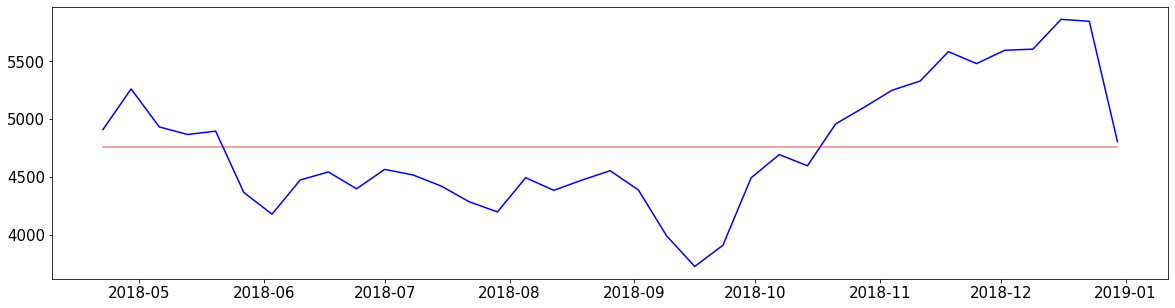

Just the mean:  9.317824438571847 %


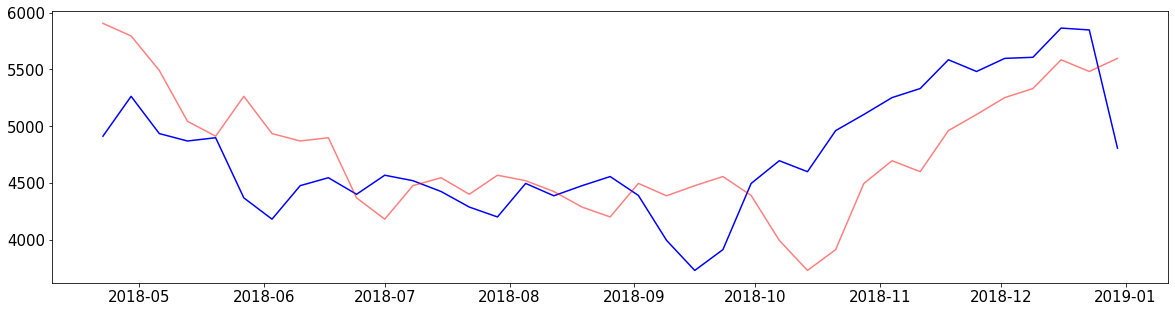

Use past known value:  9.12077989793207 %


In [16]:
y_validate0=y_validate[:,-1]
y_validate0=scaler_energy.inverse_transform(y_validate0)
y_pred0=np.array([np.mean(y_validate0)]*len(y_validate0))


plt.figure(figsize=(20,5))
plt.plot_date(dates_validate,y_validate0,'b-')
plt.plot_date(dates_validate,y_pred0,'r-',alpha=0.5)
plt.show()
print('Just the mean: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

y_pred=np.array(list(y_train[-n_future:,-1])+list(y_validate[0:-n_future,-1]))
y_pred0=scaler_energy.inverse_transform(y_pred)

plt.figure(figsize=(20,5))
plt.plot_date(dates_validate,y_validate0,'b-')
plt.plot_date(dates_validate,y_pred0,'r-',alpha=0.5)
plt.show()

print('Use past known value: ',np.mean(np.abs(y_pred0-y_validate0)/y_validate0)*100,'%')

## Forecast 4 weeks (at the same time).
Use only Rain data and previous energy_generated, and demand

In [17]:
model = models.Sequential()
model.add(layers.LSTM(15,input_shape=[None,X_train.shape[2]],return_sequences=True))
model.add(layers.LSTM(15))
model.add(layers.Dense(n_future))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 15)          1560      
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dense (Dense)                (None, 4)                 64        
Total params: 3,484
Trainable params: 3,484
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])#optimizer='rmsprop'

In [19]:
np.random.seed(10)
history = model.fit(X_train,y_train,epochs = 100, validation_data=(X_validate,y_validate), verbose=0)

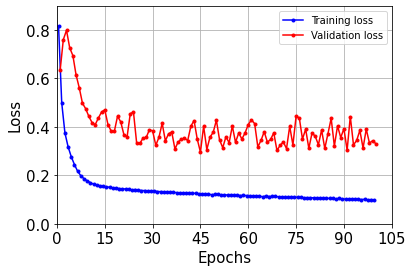

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

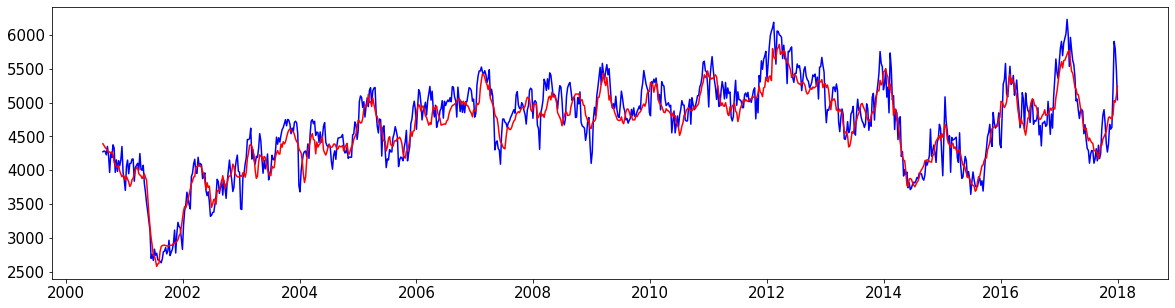

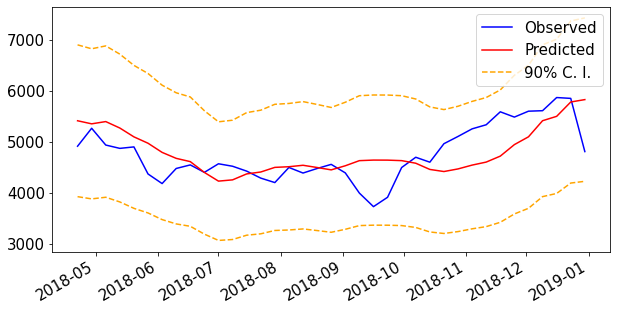

Validate error:  7.745601056938069 %


In [21]:
weeks_ahead=n_future
weeks_ahead=4

#Train Data
y_pred=model.predict(X_train)
y_train0=y_train[:,weeks_ahead-1]
y_pred0=y_pred[:,weeks_ahead-1]

y_pred0=scaler_energy.inverse_transform(y_pred0)
y_train0=scaler_energy.inverse_transform(y_train0)

plt.figure(figsize=(20,5))
plt.plot_date(dates_train,y_train0,'b-')
plt.plot_date(dates_train,y_pred0,'r-')
plt.show()

#Validate Data
y_pred=model.predict(X_validate)
y_validate0=y_validate[:,weeks_ahead-1]
y_pred0=y_pred[:,weeks_ahead-1]

y_pred0=scaler_energy.inverse_transform(y_pred0)
y_validate0=scaler_energy.inverse_transform(y_validate0)


sd_perc_error=np.std((y_pred0-y_validate0)/y_validate0)
mean_perc_error=np.mean(np.abs(y_pred0-y_validate0)/y_validate0)

error_term=(2*sd_perc_error+mean_perc_error)
y_pred_up=(1+error_term)*y_pred0
y_pred_btm=(1-error_term)*y_pred0


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot_date(dates_validate,y_validate0,'b-', label='Observed')
ax.plot_date(dates_validate,y_pred0,'r-', label='Predicted')
ax.plot_date(dates_validate,y_pred_up,'--', color='orange', label='90% C. I.')
ax.plot_date(dates_validate,y_pred_btm,'--', color='orange')
fig.autofmt_xdate()
ax.legend(loc='upper right')
plt.show()


print('Validate error: ',mean_perc_error*100,'%')

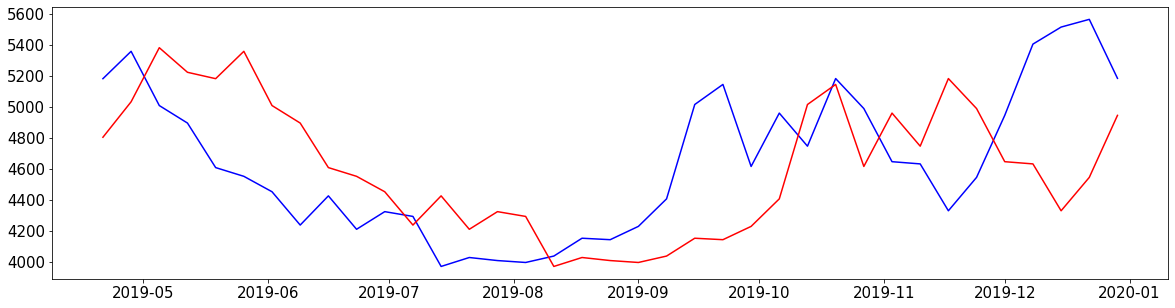

Use past known value:  8.876543159671469 %


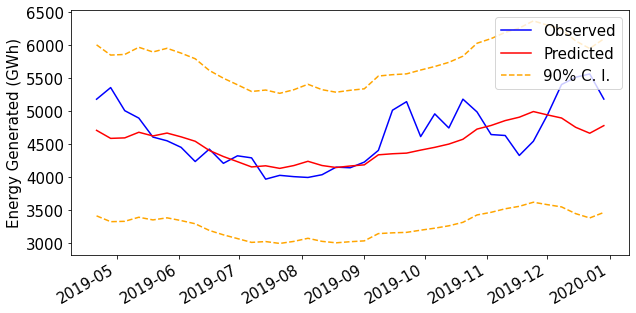

Test error:  6.103439200139463 %


In [24]:
y_test0=scaler_energy.inverse_transform(y_test[:,weeks_ahead-1])

y_pred=np.array([y_validate[-1,-1]]+list(y_test[0,:-1])+list(y_test[0:-n_future,-1]))
y_pred0=scaler_energy.inverse_transform(y_pred)

plt.figure(figsize=(20,5))
plt.plot_date(dates_test,y_test0,'b-')
plt.plot_date(dates_test,y_pred0,'r-')
plt.show()

print('Use past known value: ',np.mean(np.abs(y_pred0-y_test0)/y_test0)*100,'%')

#With the Neural Net
y_pred=model.predict(X_test)
y_pred0=y_pred[:,weeks_ahead-1]

y_pred0=scaler_energy.inverse_transform(y_pred0)


y_pred_up=(1+error_term)*y_pred0
y_pred_btm=(1-error_term)*y_pred0


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot_date(dates_test,y_test0,'b-', label='Observed')
ax.plot_date(dates_test,y_pred0,'r-', label='Predicted')
ax.plot_date(dates_test,y_pred_up,'--', color='orange', label='90% C. I.')
ax.plot_date(dates_test,y_pred_btm,'--', color='orange')
fig.autofmt_xdate()
ax.legend(loc='upper right')
plt.ylabel('Energy Generated (GWh)')
plt.show()

mean_perc_error=np.mean(np.abs(y_pred0-y_test0)/y_test0)

print('Test error: ',mean_perc_error*100,'%')

In [23]:
DF[DF.date<=date_test].shape

(1026, 11)